본 튜토리얼은 Semi-Supervised Learning의 하위 분야 가운데 Hybrid/Holistic Method에 관련한 내용을 진행합니다.

선택한 모델은 제가 지난 pair study 과정에서 다룬 내용인 MixMatch, FixMatch, FlexMatch을 구현하겠습니다.


##### 우선 각 모델별로 하이퍼파라미터 선정 혹은 증강 방법 결정에 따른 결과의 차이가 있는지 알아보고,
##### 특히 MixMatch -> FixMatch -> FlexMatch의 순서로 논문이 나오고 또한 발전도 이루어진 것에 착안하여, 해당되는 부분에 있어서 결과적으로 어느정도의 차이가 있는지를 확인하는 것이 튜토리얼의 목적입니다.

## Import modules

In [1]:
import os, math, sys, argparse
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm import tqdm
from colorama import Fore
from torch.utils.data import DataLoader
from torchvision import transforms as transforms
from torch.utils.tensorboard import SummaryWriter

# MixMatch

MixMatch란 Augmentation 기법을 활용하여 unlabeled data를 활용하는 방법론입니다.

MixMatch가 진행되는 순서를 요약하면 아래의 순서와 같습니다.

    1. Labeled data인 X에 대해서 단일 Augmentation을 적용.
    2. Unlabeled data인 X'에 대해서도 여러가지 Augmentation을 적용.
    3. Unlabeled data X'에 대해 Augmentation을 적용한 결과들에 대한 평균값을 계산. -> "q_b_bar"
    4. q_b_bar에 대해서 temperature sharpening 과정을 통해 가장 높은 class의 확률 값이 다른 class의 확률 값에 비해 월등히 높도록 조정. (T로 조정)
    5. Mix-up 방법을 통해 학습을 위한 데이터를 재생성. - 'X_MixSet'
    6. Augmentation이 적용된 X, X'을 Concatenate하여 데이터셋을 만들어줍니다. -> 'W set'
    7. 구성된 W set을 이용해 Mixup을 적용하여 새로운 데이터셋 'U'를 만들어 줍니다.
    8. 5번의 'X_MixSet'과 7번의 'U Set'을 이용해서 아래의 Loss function을 적용하여 학습합니다

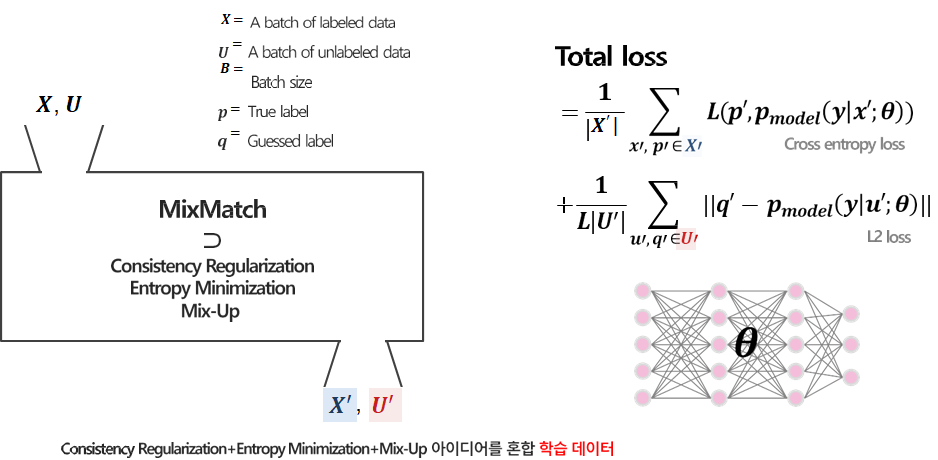

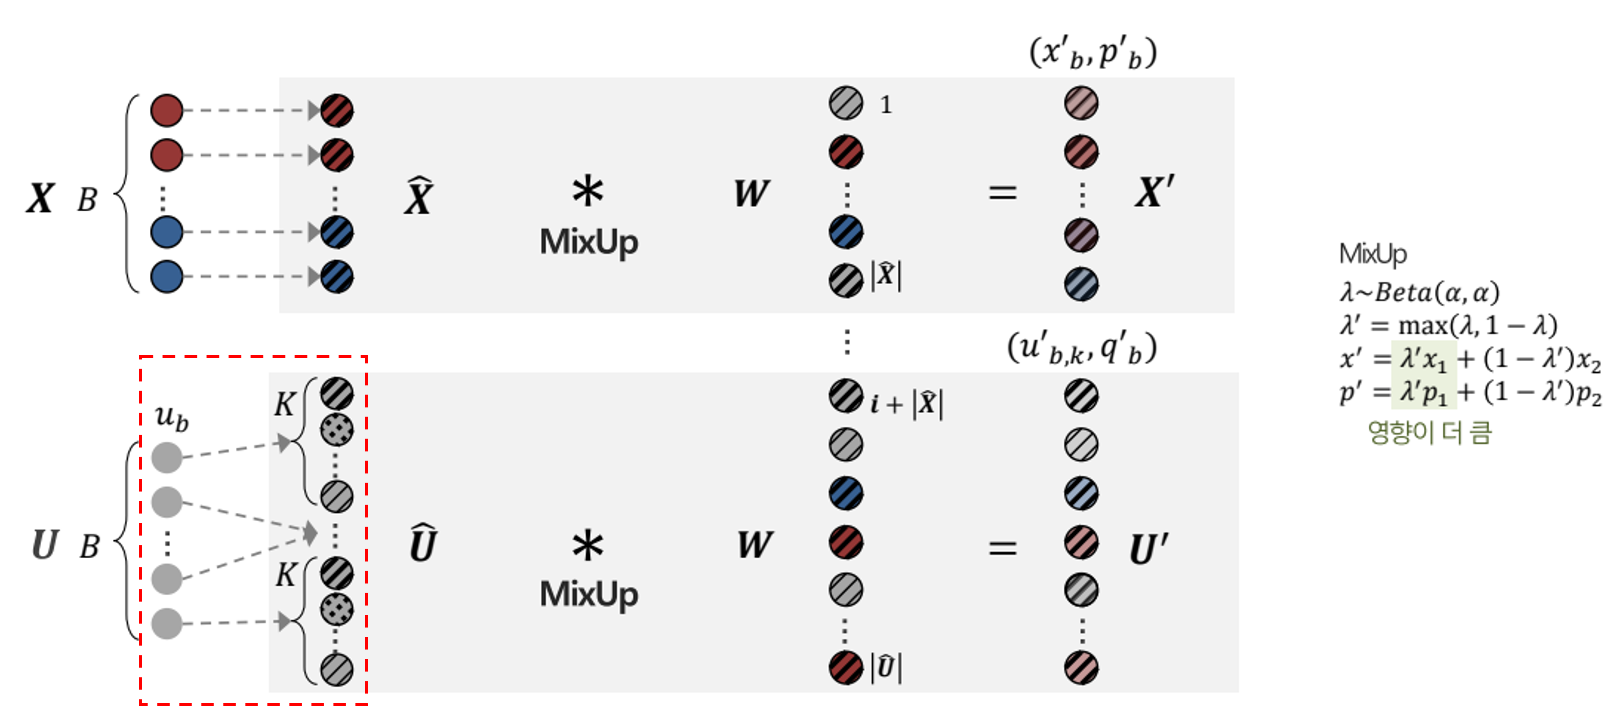

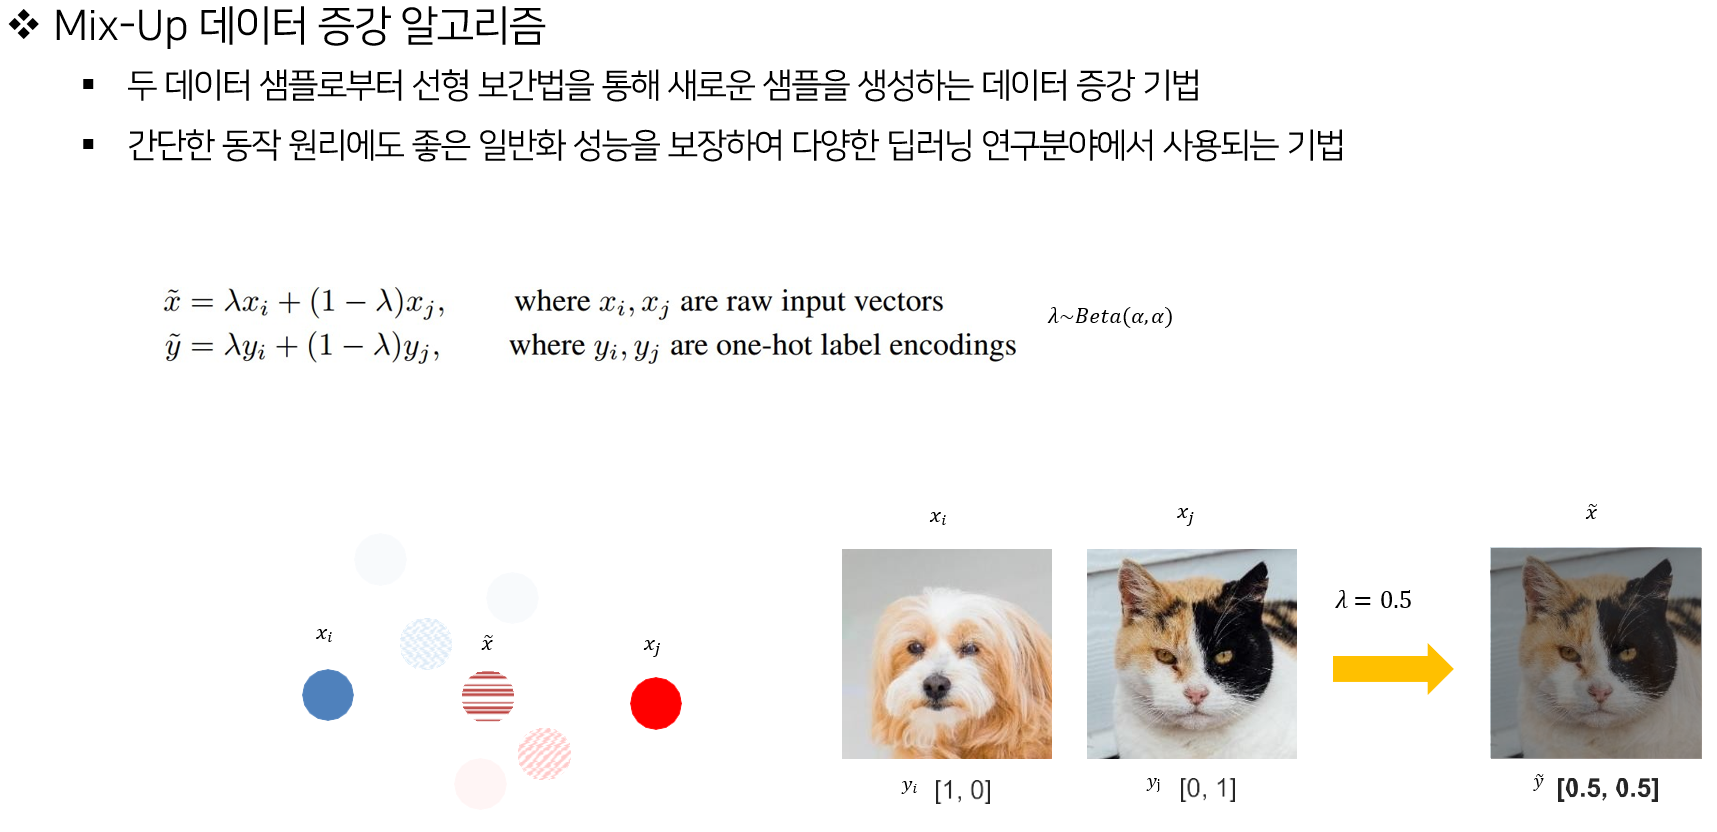

이번 튜토리얼에서는 MixMatch에서 여러 weak augmentation을 사용한다고 할 때, 증강기법별로 결과 성능에 영향을 주는지 비교하려고 하고,

추가로, 데이터 Mix-Up 부분에서의 데이터 선형 보간에 대하여 $\lambda 비율의 변화에 따른 결과를 비교하고자 한다.

개인적인 추측으로는 증강기법에 의한 차이는 없다고 알고 있지만 unlabeled dataset에 적용하는 케이스에서도 그런지 실제로 확인을 해보고싶고,

데이터 선형 보간에 의한 결과는 예상대로 0.5가 제일 균형있게 보여서 좋은 결과가 나올 것 같은데 이 부분을 분류 정확도를 통해서 확인해보고자 한다.

# Load datasets

##### CIFAR10 : 이미지 분류에서 가장 많이 사용되는 데이터셋으로, 10개의 대분류 Class를 중심으로 각 Class별 6,000장의 이미지를 포함하고 있는 데이터셋.
##### 총 60,000장 가운데 Train:Test의 비율은 각 class별로 5:1로 되어있음

- 각 class별로 매우 상이한 차이가 있는 이미지 데이터셋이기 때문에 (e.g., ariplane V.S. frog),
- 가장 기본적인 이미지 분류 데이터셋으로 활용하고 있고, 조금 더 세밀하거나 더 다양한 범주와 더 많은 이미지 데이터 분류를 희망한다면 다른 데이터셋을 추가 사용하는 것을 추천드립니다.

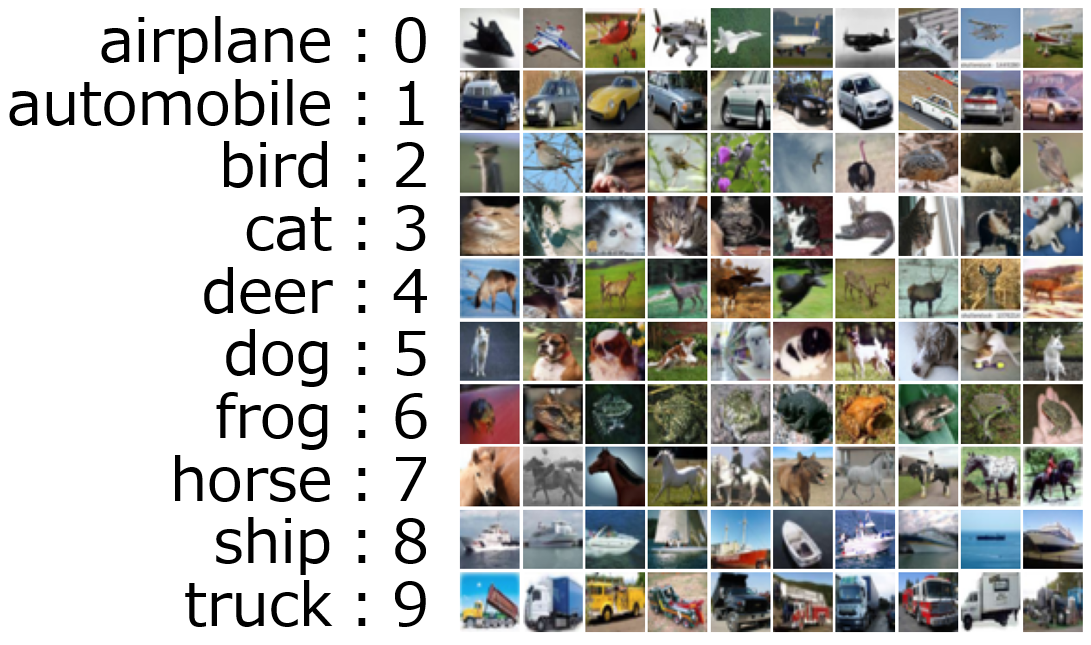

- 이미지 출처: https://www.cs.toronto.edu/~kriz/cifar.html

CIFAR-10은 pytorch에 내장되어 있어 쉽게 dataset을 구축할 수 있다. 하지만 self-training을 위해서는 unlabeled data의 index가 있어야지만 unlabeled data에서 pseudo label을 할 data를 식별 할 수 있다.

따라서 아래와 같이 2가지의 방법을 진행하였다.

1) label dataset은 정상적으로 데이터를 읽어오는 과정을 거치고,

2) unlabeled dataset의 경우에는, 데이터를 읽어오는 과정에서 라벨을 모두 -1로 처리하는 트릭을 사용한다.

In [2]:
# Labeled data를 생성하는 함수

class Labeled_CIFAR10(torchvision.datasets.CIFAR10):
    
    def __init__(self, root, indices=None,
                train=True, transform=None,
                target_transform=None, download=False):
        
        super(Labeled_CIFAR10, self).__init__(root,
                                        train=train,
                                        transform=transform,
                                        target_transform=target_transform,
                                        download=download)

        if indices is not None:
            self.data = self.data[indices]
            self.targets = np.array(self.targets)[indices]
        
        self.data = Transpose(Normalize(self.data))
    
    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target

In [3]:
# Unlabeled data를 생성하는 함수

'''
Unlabeled data의 Label은 -1로 지정
'''

class Unlabeled_CIFAR10(Labeled_CIFAR10):
    
    def __init__(self, root, indices, train=True, transform=None, target_transform=None, download=False):
        
        super(Unlabeled_CIFAR10, self).__init__(root, indices, train,
                                            transform=transform,
                                            target_transform=target_transform,
                                            download=download)
        
        self.targets = np.array([-1 for i in range(len(self.targets))])

In [4]:
# 데이터셋을 분할하기 위해서 Index를 섞는 함수 정의

def split_datasets(labels, n_labeled_per_class):
    
    '''
    - n_labeled_per_class: labeled data의 개수
    - 클래스 내 500개 데이터는 validation data로 정의
    - 클래스 당 n_labeled_per_class 개수 만큼 labeled data로 정의
    - 나머지 이미지는 unlabeled data로 정의
    '''
    
    ### labeled, unlabeled, validation data 분할할 list 초기화
    labels = np.array(labels, dtype=int) 
    indice_labeled, indice_unlabeled, indice_val = [], [], [] 
    
    ### 각 class 단위로 loop 생성
    for i in range(10): 

        # 각각 labeled, unlabeled, validation data를 할당
        indice_tmp = np.where(labels==i)[0]
        
        indice_labeled.extend(indice_tmp[: n_labeled_per_class])
        indice_unlabeled.extend(indice_tmp[n_labeled_per_class: -500])
        indice_val.extend(indice_tmp[-500: ])
    
    ### 각 index를 Shuffle
    for i in [indice_labeled, indice_unlabeled, indice_val]:
        np.random.shuffle(i)
    
    return indice_labeled, indice_unlabeled, indice_val

In [5]:
# Custom Transform 함수 정의 --> 2가지 종류의 Augmentation 산출

class Transform_Twice:
    
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, img):
        out1 = self.transform(img)
        out2 = self.transform(img)
        
        return out1, out2

In [6]:
# CIFAR10에 대하여 labeled, unlabeled, validation, test dataset 생성

def get_cifar10(data_dir: str, n_labeled: int,
                transform_train=None, transform_val=None,
                download=True):
    
    ### Torchvision에서 제공해주는 CIFAR10 dataset Download
    base_dataset = torchvision.datasets.CIFAR10(data_dir, train=True, download=download)
    
    ### labeled, unlabeled, validation data에 해당하는 index를 가져오기
    indice_labeled, indice_unlabeled, indice_val = split_datasets(base_dataset.targets, int(n_labeled/10)) ### n_labeled는 아래 MixMatch_argparser 함수에서 정의
    
    ### index를 기반으로 dataset을 생성
    '''
    왜 unlabeled가 Transform_twice가 적용되었을까?
    '''
    train_labeled_set = Labeled_CIFAR10(data_dir, indice_labeled, train=True, transform=transform_train) 
    train_unlabeled_set = Unlabeled_CIFAR10(data_dir, indice_unlabeled, train=True, transform=Transform_Twice(transform_train))
    val_set = Labeled_CIFAR10(data_dir, indice_val, train=True, transform=transform_val, download=True) 
    test_set = Labeled_CIFAR10(data_dir, train=False, transform=transform_val, download=True) 

    return train_labeled_set, train_unlabeled_set, val_set, test_set

In [7]:
# Image를 전처리 하기 위한 함수

### 데이터를 정규화 하기 위한 함수
def Normalize(x, m=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2345, 0.2616)):
        
    ##### x, m, std를 각각 array화
    x, m, std = [np.array(a, np.float32) for a in (x, m, std)] 

    ##### 데이터 정규화
    x -= m * 255 
    x *= 1.0/(255*std)
    return x

### 데이터를 (B, C, H, W)로 수정해주기 위한 함수 (from torchvision.transforms 내 ToTensor 와 동일한 함수)
def Transpose(x, source='NHWC', target='NCHW'):
    return x.transpose([source.index(d) for d in target])

### 특정 이미지에 동서남북 방향으로 4만큼 픽셀을 추가해주기 위한 학습
def pad(x, border=4):
    return np.pad(x, [(0, 0), (border, border), (border, border)], mode='reflect')

In [8]:
# Image를 Augmentation하기 위한 함수

### Image를 Padding 및 Crop적용
class RandomPadandCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, x):
        x = pad(x, 4)
        
        old_h, old_w = x.shape[1: ]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, old_h-new_h)
        left = np.random.randint(0, old_w-new_w)
        
        x = x[:, top:top+new_h, left:left+new_w]
        return x
    
    
### RandomFlip하는 함수 정의
class RandomFlip(object):
    def __call__(self, x):
        if np.random.rand() < 0.5:
            x = x[:, :, ::-1]
        
        return x.copy()
    
    
### GaussianNoise를 추가하는 함수 정의
class GaussianNoise(object):
    def __call__(self, x):
        c, h, w = x.shape
        x += np.random.randn(c, h, w)*0.15
        return x

In [9]:
# Numpy를 Tensor로 변환하는 함수
class ToTensor(object):
    def __call__(self, x):
        x = torch.from_numpy(x)
        return x

# Backborn classifier (WideResNet)

논문에서 설명된 것 처럼 WideResNet을 통해 분류기를 구현했습니다. WideResNet 코드의 경우, 직접 구현하지 않고 아래의 github 링크에서 발췌하여 사용하였습니다.

WideResNet(WRN)에 대한 간략한 설명을 하자면 다음과 같습니다.

WRN은 residual netowrk의 넓이를 증가시키고 깊이를 감소시킨 모델. 16 layer로 이루어진 WRN은 1000-layer ResNet 같은 깊은 신경망을 제치고 SOTA를 달성 (2016년).

신경망의 넓이를 증가한다는 의미는 filter수를 증가시킨다는 것을 의미합니다. 즉, WRN은 residual block을 구성하는 convolution layer의 filter 수를 증가시켜서 신경망의 넓이를 증가시켰습니다.

따라서, WRN은 (1) 문제를 넓이를 증가시켜서 해결하려 하고, (2) 문제는 residual block 내에있는 conv layer 사이에 dropout을 적용하여 해결합니다.

- diminishig feature reuse 문제를 다루기 위해 residual block에 dropout을 적용

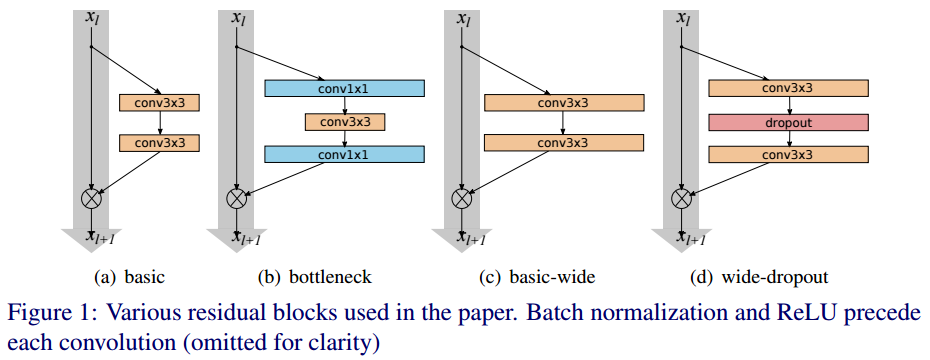

- 이 구조는 모델을 얇게 해 parameter 수를 감소시켜 깊이를 증가시킵니다. residual block을 최대한 얇게 구성하여 모델의 깊이를 엄청나게 증가시킴

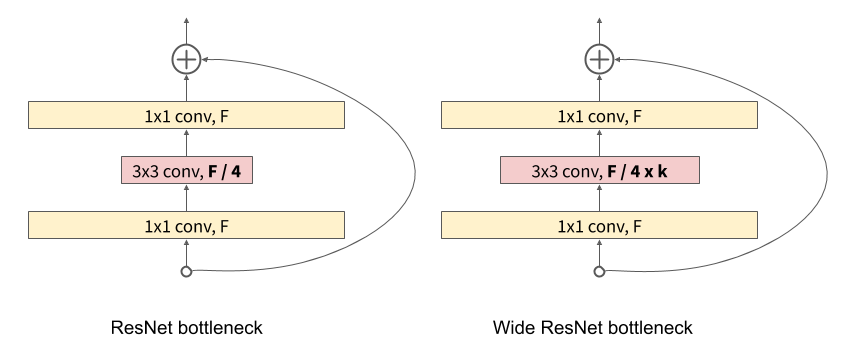

- 출처: https://github.com/xternalz/WideResNet-pytorch/blob/master/wideresnet.py

- 출처: https://deep-learning-study.tistory.com/519

In [10]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
        self.activate_before_residual = activate_before_residual
    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

In [11]:
class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0, activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate, activate_before_residual)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate, activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate, activate_before_residual))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

In [12]:
class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

# Semi-supervised loss function

- Semi-supervised loss = $Loss(Labeled, x) + \lambda \times Loss(Unlabeled, u)$

In [13]:
class Loss_Semisupervised(object):
    def __call__(self, args, outputs_x, target_x, outputs_u, targets_u, epoch):
        self.args = args
        probs_u = torch.softmax(outputs_u, dim=1)

        loss_x = -torch.mean(
            torch.sum(F.log_softmax(outputs_x, dim=1)*target_x, dim=1)
        )

        loss_u = torch.mean((probs_u-targets_u)**2)

        return loss_x, loss_u, self.args.lambda_u*linear_rampup(epoch, self.args.epochs)

In [14]:
def linear_rampup(current, rampup_length):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current/rampup_length, 0.0, 1.0)
        return float(current)

In [15]:
class WeightEMA(object): # EMA=Exponential Moving Average
    
    '''
    이를 하는 이유는 학습시간이 길어지거나, Trivial Solution을 방지, 과적합 방지 등. --> 가중치를 업데이트 시 a(최근가중치)+(1-a)(이전가중치)
    '''
    def __init__(self, model, ema_model, lr, alpha=0.999):
        self.model = model
        self.ema_model = ema_model

        self.alpha = alpha

        self.params = list(self.model.state_dict().items())
        self.ema_params = list(self.ema_model.state_dict().items())

        self.wd = 0.02 * lr

        for param, ema_param in zip(self.params, self.ema_params):
            param[1].data.copy_(ema_param[1].data)
    
    def step(self):
        inverse_alpha = 1.0 - self.alpha
        for param, ema_param in zip(self.params, self.ema_params):
            if ema_param[1].dtype == torch.float32:
                ema_param[1].mul_(self.alpha) # ema_params_new = self.alpha * ema_params_old
                ema_param[1].add_(param[1]*inverse_alpha) # ema_params_Double_new = (1-self.alpha)*params

                # summary: ema_params_new = self.alpha*ema_params_old + (1-self.alpha)*params
                # params: 학습되고 있는 모델 parameter
                param[1].mul_(1-self.wd)

In [16]:
def interleave_offsets(batch_size, nu):
    
    '''
    이것도 assert의 목적으로 활용되는 code
    '''
    
    groups = [batch_size//(nu+1)]*(nu+1)
    for x in range(batch_size-sum(groups)):
        groups[-x-1] += 1

    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1]+g)
    
    assert offsets[-1] == batch_size
    return offsets

In [17]:
def interleave(xy, batch_size):
    
    '''
    이것도 assert의 목적으로 활용되는 code
    '''
    
    nu = len(xy) - 1
    offsets = interleave_offsets(batch_size, nu)

    xy = [[v[offsets[p]:offsets[p+1]] for p in range(nu+1)] for v in xy]
    for i in range(1, nu+1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]

In [18]:
def get_tqdm_config(total, leave=True, color='white'):
    fore_colors = {
        'red': Fore.LIGHTRED_EX,
        'green': Fore.LIGHTGREEN_EX,
        'yellow': Fore.LIGHTYELLOW_EX,
        'blue': Fore.LIGHTBLUE_EX,
        'magenta': Fore.LIGHTMAGENTA_EX,
        'cyan': Fore.LIGHTCYAN_EX,
        'white': Fore.LIGHTWHITE_EX,
    }
    return {
        'file': sys.stdout,
        'total': total,
        'desc': " ",
        'dynamic_ncols': True,
        'bar_format':
            "{l_bar}%s{bar}%s| [{elapsed}<{remaining}, {rate_fmt}{postfix}]" % (fore_colors[color], Fore.RESET),
        'leave': leave
    }

# Evaluation metric

top1 accuracy, top5 accuracy

    - top1 accuracy: (확률 값이 가장 높은 범주와 실제 범주가 일치하는 관측치 수)/ 전체 관측치
    - top5 accuracy: (확률 값 상위 5개 중 실제 범주가 존재하는 관측치 수)/ 전체 관측치

In [19]:
def accuracy(output, target, topk=(1, )):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        if k == 1:
            correct_k = correct[:k].view(-1).float().sum(0)
        if k > 1:
            correct_k = correct[:k].float().sum(0).sum(0)
        acc = correct_k.mul_(100.0 / batch_size)
        acc = acc.detach().cpu().numpy()
        res.append(acc)
    return res

# Train & Test with MixMatch using WideResnet

In [20]:
class MixMatchTrainer():
    def __init__(self, args):
        self.args = args

        root_dir = '/content/MixMatch' # PROJECT directory
        self.experiment_dir = os.path.join(root_dir, 'results') # 학습된 모델을 저장할 폴더 경로 정의 및 폴더 생성
        os.makedirs(self.experiment_dir, exist_ok=True)

        name_exp = "_".join([str(self.args.n_labeled), str(self.args.T)]) # 주요 하이퍼 파라미터로 폴더 저장 경로 지정 
        self.experiment_dir = os.path.join(self.experiment_dir, name_exp)
        os.makedirs(self.experiment_dir, exist_ok=True)

        # Data
        print("==> Preparing CIFAR10 dataset")
        transform_train = transforms.Compose([
            RandomPadandCrop(32),
            RandomFlip(),
            GaussianNoise(),
            ToTensor()
        ]) # 학습에 사용할 data augmentation 정의

        transform_val = transforms.Compose([
            ToTensor()
        ]) # validation, test dataset에 대한 data augmentation 정의
           # 합성곱 신경망에 입력 될 수 있도록만 지정(Augmentation 사용하지 않는 것과 동일)

        train_labeled_set, train_unlabeled_set, val_set, test_set = \
            get_cifar10(
                data_dir=os.path.join(root_dir, 'data'),
                n_labeled=self.args.n_labeled,
                transform_train=transform_train,
                transform_val=transform_val
            ) # 앞에서 정의한 (def) get_cifar10 함수에서 train_labeled, train_unlabeled, validation, test dataset
        
        # DataLoader 정의
        self.labeled_loader = DataLoader(
            dataset=train_labeled_set,
            batch_size=self.args.batch_size,
            shuffle=True, num_workers=0, drop_last=True
        )

        self.unlabeled_loader = DataLoader(
            dataset=train_unlabeled_set,
            batch_size=self.args.batch_size,
            shuffle=True, num_workers=0, drop_last=True
        )

        self.val_loader = DataLoader(
            dataset=val_set, shuffle=False, num_workers=0, drop_last=False
        )

        self.test_loader = DataLoader(
            dataset=test_set, shuffle=False, num_workers=0, drop_last=False
        )

        # Build WideResNet
        print("==> Preparing WideResNet")
        self.model = self.create_model(ema=False)
        self.ema_model = self.create_model(ema=True)

        # Define loss functions
        self.criterion_train = Loss_Semisupervised()
        self.criterion_val = nn.CrossEntropyLoss().to(self.args.cuda)

        # Define optimizers
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.ema_optimizer = WeightEMA(self.model, self.ema_model, lr=self.args.lr, alpha=self.args.ema_decay)

        # 학습 결과를 저장할 Tensorboard 정의
        self.writer = SummaryWriter(self.experiment_dir)

    def create_model(self, ema=False):
        # Build WideResNet & EMA model
        model = WideResNet(num_classes=10)
        model = model.to(self.args.cuda)

        if ema:
            for param in model.parameters():
                param.detach_()
            
        return model
    
    def train(self, epoch):
        # 모델 학습 함수
        losses_t, losses_x, losses_u, ws = 0.0, 0.0, 0.0, 0.0
        self.model.train()

        # iter & next remind
        # iter: list 내 batch size 만큼 랜덤하게 불러오게 하는 함수
        # next: iter 함수가 작동하도록 하는 명령어
        iter_labeled = iter(self.labeled_loader)
        iter_unlabeled = iter(self.unlabeled_loader)

        with tqdm(**get_tqdm_config(total=self.args.num_iter,
                leave=True, color='blue')) as pbar:
            for batch_idx in range(self.args.num_iter):
                # 왜 try-except 문을 사용하나?
                # 코드 작성 후 iter&next가 정확히 작용하지 않는 경우가 있음을 확인
                # 다시 iter_labeled, iter_unlabeled를 정의해 학습에 문제가 없도록 다시 선언
                try:
                    inputs_x, targets_x = next(iter_labeled)
                except:
                    iter_labeled = iter(self.labeled_loader)
                    inputs_x, targets_x = next(iter_labeled)
                real_B = inputs_x.size(0)

                # Transform label to one-hot
                targets_x = torch.zeros(real_B, 10).scatter_(1, targets_x.view(-1,1).long(), 1)
                inputs_x, targets_x = inputs_x.to(self.args.cuda), targets_x.to(self.args.cuda)

                try:
                    tmp_inputs, _ = next(iter_unlabeled)
                except:
                    iter_unlabeled = iter(self.unlabeled_loader)
                    tmp_inputs, _ = next(iter_unlabeled)

                inputs_u1, inputs_u2 = tmp_inputs[0], tmp_inputs[1]
                inputs_u1, inputs_u2 = inputs_u1.to(self.args.cuda), inputs_u2.to(self.args.cuda)

                # Unlabeled data에 대한 실제 값 생성
                # 서로 다른 Augmentation 결과의 출력 값의 평균 계산
                # Temperature 값으로 실제 값 스케일링
                with torch.no_grad():
                    outputs_u1 = self.model(inputs_u1)
                    outputs_u2 = self.model(inputs_u2)

                    pt = (torch.softmax(outputs_u1, dim=1)+torch.softmax(outputs_u2, dim=1)) / 2
                    pt = pt**(1/self.args.T)

                    targets_u = pt / pt.sum(dim=1, keepdim=True)
                    targets_u = targets_u.detach()
                
                # MixUp
                # 서로 다른 이미지와 레이블을 섞는 작업
                # feature space 상에서 범주 별 Decision boundary를 정확하게 잡아주는 역할
                inputs = torch.cat([inputs_x, inputs_u1, inputs_u2], dim=0)
                targets = torch.cat([targets_x, targets_u, targets_u], dim=0)

                l_mixup = np.random.beta(self.args.alpha, self.args.alpha)
                l_mixup = max(l_mixup, 1-l_mixup)

                # inputs의 index를 섞어 서로 다른 범주끼리 섞도록 하는 역할
                B = inputs.size(0)
                random_idx = torch.randperm(B)

                inputs_a, inputs_b = inputs, inputs[random_idx]
                targets_a, targets_b = targets, targets[random_idx]

                mixed_input = l_mixup*inputs_a + (1-l_mixup)*inputs_b
                mixed_target = l_mixup*targets_a + (1-l_mixup)*targets_b

                # batch size 만큼 분할 진행 (2N, C, H, W) -> (N, C, H, W) & (N, C, H, W)
                # 앞 부분은 labeled, 뒷 부분은 unlabeled
                '''
                이렇게 하는 이유는 첫 B는 Label 데이터로 활용, 나중 B는 Unlabeled data로 활용하기 위함 (관용적 활용법)
                '''
                
                mixed_input = list(torch.split(mixed_input, real_B))
                mixed_input = interleave(mixed_input, real_B)

                logits = [self.model(mixed_input[0])] # for labeled
                for input in mixed_input[1:]:
                    logits.append(self.model(input)) # for unlabeled

                logits = interleave(logits, real_B) # interleave: 정확히 섞이었는지 확인
                logits_x = logits[0]
                logits_u = torch.cat(logits[1:], dim=0)

                loss_x, loss_u, w = \
                    self.criterion_train(self.args,
                                    logits_x, mixed_target[:real_B],
                                    logits_u, mixed_target[real_B:],
                                    epoch+batch_idx/self.args.num_iter) # Semi-supervised loss 계산

                loss = loss_x + w * loss_u

                # Backpropagation and Model parameter update
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.ema_optimizer.step()

                losses_x += loss_x.item()
                losses_u += loss_u.item()
                losses_t += loss.item()
                ws += w

                self.writer.add_scalars(
                    'Training steps', {
                        'Total_loss': losses_t/(batch_idx+1),
                        'Labeled_loss':losses_x/(batch_idx+1),
                        'Unlabeled_loss':losses_u/(batch_idx+1),
                        'W values': ws/(batch_idx+1)
                    }, global_step=epoch*self.args.batch_size+batch_idx
                )

                pbar.set_description(
                    '[Train(%4d/ %4d)-Total: %.3f|Labeled: %.3f|Unlabeled: %.3f]'%(
                        (batch_idx+1), self.args.num_iter,
                        losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)
                    )
                )
                pbar.update(1)

            pbar.set_description(
                '[Train(%4d/ %4d)-Total: %.3f|Labeled: %.3f|Unlabeled: %.3f]'%(
                    epoch, self.args.epochs,
                    losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)
                )
            )
        
        return losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)

    @torch.no_grad()
    def validate(self, epoch, phase):
        self.ema_model.eval()

        # Train, Validation, Test dataset 에 대한 DataLoader를 정의
        if phase == 'Train':
            data_loader = self.labeled_loader
            c = 'blue'
        elif phase == 'Valid':
            data_loader = self.val_loader
            c = 'green'
        elif phase == 'Test ':        
            data_loader = self.test_loader
            c = 'red'

        losses = 0.0
        top1s, top5s = [], []

        with tqdm(**get_tqdm_config(total=len(data_loader),
                leave=True, color=c)) as pbar:
            for batch_idx, (inputs, targets) in enumerate(data_loader):
                
                targets = targets.type(torch.LongTensor)
                inputs, targets = inputs.to(self.args.cuda), targets.to(self.args.cuda)
                outputs = self.ema_model(inputs)
                
                loss = self.criterion_val(outputs, targets)
                # labeled dataset에 대해서만 손실함수 계산
                # torch.nn.CrossEntropyLoss()를 사용해서 손실함수 계산

                prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
                losses += loss.item()
                top1s.append(prec1)
                top5s.append(prec5)

                self.writer.add_scalars(
                    f'{phase} steps', {
                        'Total_loss': losses/(batch_idx+1),
                        'Top1 Acc': np.mean(top1s),
                        'Top5 Acc': np.mean(top5s)
                    }, global_step=epoch*self.args.batch_size+batch_idx
                )

                pbar.set_description(
                    '[%s-Loss: %.3f|Top1 Acc: %.3f|Top5 Acc: %.3f]'%(
                        phase,
                        losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)
                    )
                )
                pbar.update(1)

            pbar.set_description(
                '[%s(%4d/ %4d)-Loss: %.3f|Top1 Acc: %.3f|Top5 Acc: %.3f]'%(
                    phase,
                    epoch, self.args.epochs,
                    losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)
                )
            )

        return losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)

# hyperparameters setting

In [21]:
import argparse

# 실험에서 사용할 하이퍼파라미터 정의
def MixMatch_parser():
    parser = argparse.ArgumentParser(description="MixMatch from Scratch")
    
    parser.add_argument('--n-labeled', type=int, default=128) # 사용할 Labeled data의 수를 정의
    parser.add_argument('--num-iter', type=int, default=128) # 한 epoch당 포함되는 iteration의 수를 정의
    parser.add_argument('--alpha', type=float, default=0.75) # threshold를 위한 alpha값 정의 / Mix-Up 과정에서 비율을 설정 (0.5보다 클수록 l_mixup가 설정됨     max(l_mixup, 1-l_mixup) 중 하나로)
    parser.add_argument('--lambda-u', type=float, default=75) # lambda-u 값 정의
    parser.add_argument('--T', default=0.5, type=float) 
    parser.add_argument('--ema-decay', type=float, default=0.90) # exponential moving average 가중치값 조절

    parser.add_argument('--epochs', type=int, default=3) # Epoch 정의
    parser.add_argument('--batch-size', type=int, default=64) # 학습에 사용할 batch size 크기 정의
    parser.add_argument('--lr', type=float, default=0.002) # 학습률(learning rate) 조절

    return parser

# Run

In [22]:
def main():
    parser = MixMatch_parser()
    args = parser.parse_args([])
    args.cuda = torch.device("cuda:0")

    trainer = MixMatchTrainer(args)
    
    best_loss = np.inf
    # best_loss of validation 기준으로 모멜 저장

    losses, losses_x, losses_u = [], [], []
    
    train_losses, train_top1s, train_top5s = [], [], []
    val_losses, val_top1s, val_top5s = [], [], []
    test_losses, test_top1s, test_top5s = [], [], []
    # accuracy 증가 속도, loss values 감소 속도를 그래프로 그리기
    # list에 각종 값들을 저장
    for epoch in range(1, args.epochs+1, 1):
        loss, loss_x, loss_u = trainer.train(epoch)
        losses.append(loss)
        losses_x.append(loss_x)
        losses_u.append(loss_u)

        loss, top1, top5 = trainer.validate(epoch, 'Train')
        train_losses.append(loss)
        train_top1s.append(top1)
        train_top5s.append(top5)

        loss, top1, top5 = trainer.validate(epoch, 'Valid')
        val_losses.append(loss)
        val_top1s.append(top1)
        val_top5s.append(top5)

        # validation loss 기준 모델 저장
        if loss < best_loss:
            best_loss = loss
            torch.save(trainer.model, os.path.join(trainer.experiment_dir, 'model.pth'))
            torch.save(trainer.ema_model, os.path.join(trainer.experiment_dir, 'ema_model.pth'))

        loss, top1, top5 = trainer.validate(epoch, 'Test ')
        test_losses.append(loss)
        test_top1s.append(top1)
        test_top5s.append(top5)

        torch.save(trainer.model, os.path.join(trainer.experiment_dir, 'checkpooint_model.pth'))
        torch.save(trainer.ema_model, os.path.join(trainer.experiment_dir, 'checkpoint_ema_model.pth'))

In [23]:
if __name__=="__main__":
    main()

==> Preparing CIFAR10 dataset
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Preparing WideResNet
[Train(   1/    3)-Total: 2.081|Labeled: 1.713|Unlabeled: 0.010]: 100%|██████████████████████| [00:13<00:00,  9.37it/s]
[Train(   1/    3)-Loss: 16.115|Top1 Acc: 18.750|Top5 Acc: 71.875]: 100%|████████████████████| [00:00<00:00, 43.76it/s]
[Valid(   1/    3)-Loss: 22.673|Top1 Acc: 13.800|Top5 Acc: 54.440]: 100%|███████████████████| [00:35<00:00, 141.08it/s]
[Test (   1/    3)-Loss: 23.263|Top1 Acc: 12.950|Top5 Acc: 54.350]: 100%|███████████████████| [01:29<00:00, 111.64it/s]
[Train(   2/    3)-Total: 2.102|Labeled: 1.442|Unlabeled: 0.010]: 100%|██████████████████████| [00:11<00:00, 10.67it/s]
[Train(   2/    3)-Loss: 5.623|Top1 Acc: 37.500|Top5 Acc: 75.000]: 100%|█████████████████████| [00:00<00:00, 55.74it/s]
[Valid(   2/    3)-Loss: 10.156|Top1 Acc: 19.380|Top5 Acc: 60.420]: 100%|███████████████████| [00:36<00:00, 136

실험 결과를 보면, 우선 학습을 위한 파라미터 설정에 있어서 '--n-labeled' (# 사용할 Labeled data의 수) = 128로 그렇게 많지 않은 labeled data를 주어서 학습이 잘 안될것이라는 예상을 했습니다.

추가로, '--num-iter' (# 한 epoch당 포함되는 iteration의 수) = 128로 반복의 수도 비교적 적게 설정했고,

'--epochs' (# Epoch 정의) = 3으로 epoch도 적게, '--batch-size' (# 학습에 사용할 batch size 크기) = 64로 설정하여

그리 좋은 분류 성능이 나올것이라는 예상은 하지 않았지만 결과를 보면 나름 흥미로운 점이 있었습니다.

epoch이 진행될수록, 모든 데이터셋 경우에 대한 Top1, Top5 분류 정확도가 모두 증가하는 것을 확인할 수 있었습니다.

    - train set에 대한 Top1 분류 정확도가 1: 18.750 -> 2: 37.500 -> 3: 59.375으로 증가
    - validation set에 대한 Top1 분류 정확도가 1: 13.800 -> 2: 19.380 -> 3: 25.660으로 증가
    - test set에 대한 Top1 분류 정확도가 1: 12.950 -> 2: 19.020 -> 3: 24.910으로 증가




    - train set에 대한 Top5 분류 정확도가 1: 71.875 -> 2: 75.000 -> 3: 87.500으로 증가
    - validation set에 대한 Top5 분류 정확도가 1: 54.440 -> 2: 60.420 -> 3: 66.280으로 증가
    - test set에 대한 Top5 분류 정확도가 1: 54.350 -> 2: 60.800 -> 3: 67.110으로 증가

## Hyperparameter (Augmentation Methods, $l$_$mixup$ $\in [0,1]$)

이어서, MixMatch의 데이터 관련 파라미터를 변경하였을 때는 어떤 결과가 있을지 비교를 해보겠습니다.

변경할 파라미터와 실험할 값은 아래에 정리하였습니다.

    Augmentation Methods: ('RandomPadandCrop(32)', 'RandomFlip()', 'GaussianNoise()')
    l_mixup: ([0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ])

### Augmentation Methods ('RandomPadandCrop(32)', 'RandomFlip()', 'GaussianNoise()')

In [24]:
class MixMatchTrainer():
    def __init__(self, args):
        self.args = args

        root_dir = '/content/MixMatch' # PROJECT directory
        self.experiment_dir = os.path.join(root_dir, 'results') # 학습된 모델을 저장할 폴더 경로 정의 및 폴더 생성
        os.makedirs(self.experiment_dir, exist_ok=True)

        name_exp = "_".join([str(self.args.n_labeled), str(self.args.T)]) # 주요 하이퍼 파라미터로 폴더 저장 경로 지정 
        self.experiment_dir = os.path.join(self.experiment_dir, name_exp)
        os.makedirs(self.experiment_dir, exist_ok=True)

        # Data
        print("==> Preparing CIFAR10 dataset")
        if self.args.aug_method == 'R':
            transform_train = transforms.Compose([
    # =======================Augmentation 기법 변경하는 위치========================
                RandomPadandCrop(32),
    # =============================================================================
                ToTensor()
            ]) # 학습에 사용할 data augmentation 정의
            print("Hyperparameter: Augmentation method = RandomPadandCrop(32)")
        elif self.args.aug_method == 'F':
            transform_train = transforms.Compose([
    # =======================Augmentation 기법 변경하는 위치========================
                RandomFlip(),
    # =============================================================================
                ToTensor()
            ]) # 학습에 사용할 data augmentation 정의
            print("Hyperparameter: Augmentation method = RandomFlip()")
        else:
            transform_train = transforms.Compose([
    # =======================Augmentation 기법 변경하는 위치========================
                GaussianNoise(),
    # =============================================================================
                ToTensor()
            ]) # 학습에 사용할 data augmentation 정의
            print("Hyperparameter: Augmentation method = GaussianNoise()")
        

        transform_val = transforms.Compose([
            ToTensor()
        ]) # validation, test dataset에 대한 data augmentation 정의
           # 합성곱 신경망에 입력 될 수 있도록만 지정(Augmentation 사용하지 않는 것과 동일)

        train_labeled_set, train_unlabeled_set, val_set, test_set = \
            get_cifar10(
                data_dir=os.path.join(root_dir, 'data'),
                n_labeled=self.args.n_labeled,
                transform_train=transform_train,
                transform_val=transform_val
            ) # 앞에서 정의한 (def) get_cifar10 함수에서 train_labeled, train_unlabeled, validation, test dataset
        
        # DataLoader 정의
        self.labeled_loader = DataLoader(
            dataset=train_labeled_set,
            batch_size=self.args.batch_size,
            shuffle=True, num_workers=0, drop_last=True
        )

        self.unlabeled_loader = DataLoader(
            dataset=train_unlabeled_set,
            batch_size=self.args.batch_size,
            shuffle=True, num_workers=0, drop_last=True
        )

        self.val_loader = DataLoader(
            dataset=val_set, shuffle=False, num_workers=0, drop_last=False
        )

        self.test_loader = DataLoader(
            dataset=test_set, shuffle=False, num_workers=0, drop_last=False
        )
        
        # Build WideResNet
        print("==> Preparing WideResNet")
        self.model = self.create_model(ema=False)
        self.ema_model = self.create_model(ema=True)

        # Define loss functions
        self.criterion_train = Loss_Semisupervised()
        self.criterion_val = nn.CrossEntropyLoss().to(self.args.cuda)

        # Define optimizers
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.ema_optimizer = WeightEMA(self.model, self.ema_model, lr=self.args.lr, alpha=self.args.ema_decay)

        # 학습 결과를 저장할 Tensorboard 정의
        self.writer = SummaryWriter(self.experiment_dir)

    def create_model(self, ema=False):
        # Build WideResNet & EMA model
        model = WideResNet(num_classes=10)
        model = model.to(self.args.cuda)

        if ema:
            for param in model.parameters():
                param.detach_()
            
        return model
    
    def train(self, epoch):
        # 모델 학습 함수
        losses_t, losses_x, losses_u, ws = 0.0, 0.0, 0.0, 0.0
        self.model.train()

        # iter & next remind
        # iter: list 내 batch size 만큼 랜덤하게 불러오게 하는 함수
        # next: iter 함수가 작동하도록 하는 명령어
        iter_labeled = iter(self.labeled_loader)
        iter_unlabeled = iter(self.unlabeled_loader)

        with tqdm(**get_tqdm_config(total=self.args.num_iter,
                leave=True, color='blue')) as pbar:
            for batch_idx in range(self.args.num_iter):
                # 왜 try-except 문을 사용하나?
                # 코드 작성 후 iter&next가 정확히 작용하지 않는 경우가 있음을 확인
                # 다시 iter_labeled, iter_unlabeled를 정의해 학습에 문제가 없도록 다시 선언
                try:
                    inputs_x, targets_x = next(iter_labeled)
                except:
                    iter_labeled = iter(self.labeled_loader)
                    inputs_x, targets_x = next(iter_labeled)
                real_B = inputs_x.size(0)

                # Transform label to one-hot
                targets_x = torch.zeros(real_B, 10).scatter_(1, targets_x.view(-1,1).long(), 1)
                inputs_x, targets_x = inputs_x.to(self.args.cuda), targets_x.to(self.args.cuda)

                try:
                    tmp_inputs, _ = next(iter_unlabeled)
                except:
                    iter_unlabeled = iter(self.unlabeled_loader)
                    tmp_inputs, _ = next(iter_unlabeled)

                inputs_u1, inputs_u2 = tmp_inputs[0], tmp_inputs[1]
                inputs_u1, inputs_u2 = inputs_u1.to(self.args.cuda), inputs_u2.to(self.args.cuda)

                # Unlabeled data에 대한 실제 값 생성
                # 서로 다른 Augmentation 결과의 출력 값의 평균 계산
                # Temperature 값으로 실제 값 스케일링
                with torch.no_grad():
                    outputs_u1 = self.model(inputs_u1)
                    outputs_u2 = self.model(inputs_u2)

                    pt = (torch.softmax(outputs_u1, dim=1)+torch.softmax(outputs_u2, dim=1)) / 2
                    pt = pt**(1/self.args.T)

                    targets_u = pt / pt.sum(dim=1, keepdim=True)
                    targets_u = targets_u.detach()
                
                # MixUp
                # 서로 다른 이미지와 레이블을 섞는 작업
                # feature space 상에서 범주 별 Decision boundary를 정확하게 잡아주는 역할
                inputs = torch.cat([inputs_x, inputs_u1, inputs_u2], dim=0)
                targets = torch.cat([targets_x, targets_u, targets_u], dim=0)

                l_mixup = np.random.beta(self.args.alpha, self.args.alpha)
                l_mixup = max(l_mixup, 1-l_mixup)

                # inputs의 index를 섞어 서로 다른 범주끼리 섞도록 하는 역할
                B = inputs.size(0)
                random_idx = torch.randperm(B)

                inputs_a, inputs_b = inputs, inputs[random_idx]
                targets_a, targets_b = targets, targets[random_idx]

                mixed_input = l_mixup*inputs_a + (1-l_mixup)*inputs_b
                mixed_target = l_mixup*targets_a + (1-l_mixup)*targets_b

                # batch size 만큼 분할 진행 (2N, C, H, W) -> (N, C, H, W) & (N, C, H, W)
                # 앞 부분은 labeled, 뒷 부분은 unlabeled
                '''
                이렇게 하는 이유는 첫 B는 Label 데이터로 활용, 나중 B는 Unlabeled data로 활용하기 위함 (관용적 활용법)
                '''
                
                mixed_input = list(torch.split(mixed_input, real_B))
                mixed_input = interleave(mixed_input, real_B)

                logits = [self.model(mixed_input[0])] # for labeled
                for input in mixed_input[1:]:
                    logits.append(self.model(input)) # for unlabeled

                logits = interleave(logits, real_B) # interleave: 정확히 섞이었는지 확인
                logits_x = logits[0]
                logits_u = torch.cat(logits[1:], dim=0)

                loss_x, loss_u, w = \
                    self.criterion_train(self.args,
                                    logits_x, mixed_target[:real_B],
                                    logits_u, mixed_target[real_B:],
                                    epoch+batch_idx/self.args.num_iter) # Semi-supervised loss 계산

                loss = loss_x + w * loss_u

                # Backpropagation and Model parameter update
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.ema_optimizer.step()

                losses_x += loss_x.item()
                losses_u += loss_u.item()
                losses_t += loss.item()
                ws += w

                self.writer.add_scalars(
                    'Training steps', {
                        'Total_loss': losses_t/(batch_idx+1),
                        'Labeled_loss':losses_x/(batch_idx+1),
                        'Unlabeled_loss':losses_u/(batch_idx+1),
                        'W values': ws/(batch_idx+1)
                    }, global_step=epoch*self.args.batch_size+batch_idx
                )

                pbar.set_description(
                    '[Train(%4d/ %4d)-Total: %.3f|Labeled: %.3f|Unlabeled: %.3f]'%(
                        (batch_idx+1), self.args.num_iter,
                        losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)
                    )
                )
                pbar.update(1)

            pbar.set_description(
                '[Train(%4d/ %4d)-Total: %.3f|Labeled: %.3f|Unlabeled: %.3f]'%(
                    epoch, self.args.epochs,
                    losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)
                )
            )
        
        return losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)

    @torch.no_grad()
    def validate(self, epoch, phase):
        self.ema_model.eval()

        # Train, Validation, Test dataset 에 대한 DataLoader를 정의
        if phase == 'Train':
            data_loader = self.labeled_loader
            c = 'blue'
        elif phase == 'Valid':
            data_loader = self.val_loader
            c = 'green'
        elif phase == 'Test ':        
            data_loader = self.test_loader
            c = 'red'

        losses = 0.0
        top1s, top5s = [], []

        with tqdm(**get_tqdm_config(total=len(data_loader),
                leave=True, color=c)) as pbar:
            for batch_idx, (inputs, targets) in enumerate(data_loader):
                
                targets = targets.type(torch.LongTensor)
                inputs, targets = inputs.to(self.args.cuda), targets.to(self.args.cuda)
                outputs = self.ema_model(inputs)
                
                loss = self.criterion_val(outputs, targets)
                # labeled dataset에 대해서만 손실함수 계산
                # torch.nn.CrossEntropyLoss()를 사용해서 손실함수 계산

                prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
                losses += loss.item()
                top1s.append(prec1)
                top5s.append(prec5)

                self.writer.add_scalars(
                    f'{phase} steps', {
                        'Total_loss': losses/(batch_idx+1),
                        'Top1 Acc': np.mean(top1s),
                        'Top5 Acc': np.mean(top5s)
                    }, global_step=epoch*self.args.batch_size+batch_idx
                )

                pbar.set_description(
                    '[%s-Loss: %.3f|Top1 Acc: %.3f|Top5 Acc: %.3f]'%(
                        phase,
                        losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)
                    )
                )
                pbar.update(1)

            pbar.set_description(
                '[%s(%4d/ %4d)-Loss: %.3f|Top1 Acc: %.3f|Top5 Acc: %.3f]'%(
                    phase,
                    epoch, self.args.epochs,
                    losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)
                )
            )

        return losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)

In [25]:
Aug_methods_list = ['R', 'F', 'G']

In [28]:
for i in Aug_methods_list:
    def MixMatch_parser():
        parser = argparse.ArgumentParser(description="MixMatch from Scratch")

        parser.add_argument('--n-labeled', type=int, default=128) # 사용할 Labeled data의 수를 정의
        parser.add_argument('--num-iter', type=int, default=128) # 한 epoch당 포함되는 iteration의 수를 정의
        parser.add_argument('--alpha', type=float, default=0.75) # threshold를 위한 alpha값 정의
        parser.add_argument('--lambda-u', type=float, default=75) # lambda-u 값 정의
        parser.add_argument('--T', default=0.5, type=float) 
        parser.add_argument('--ema-decay', type=float, default=0.90) # exponential moving average 가중치값 조절
        
        parser.add_argument('--aug-method', type=str, default=i) # exponential moving average 가중치값 조절

        parser.add_argument('--epochs', type=int, default=5) # Epoch 정의
        parser.add_argument('--batch-size', type=int, default=64) # 학습에 사용할 batch size 크기 정의
        parser.add_argument('--lr', type=float, default=0.002) # 학습률(learning rate) 조절

        return parser

    if __name__=="__main__":
        main()
    
    print ("\n")
    print ("\n")
    print ("Training is done")
    print ("\n")
    print ("\n")

==> Preparing CIFAR10 dataset
Hyperparameter: Augmentation method = RandomPadandCrop(32)
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Preparing WideResNet
[Train(   1/    5)-Total: 1.696|Labeled: 1.470|Unlabeled: 0.010]: 100%|██████████████████████| [00:09<00:00, 12.89it/s]
[Train(   1/    5)-Loss: 43.083|Top1 Acc: 18.750|Top5 Acc: 53.125]: 100%|████████████████████| [00:00<00:00, 55.74it/s]
[Valid(   1/    5)-Loss: 52.859|Top1 Acc: 12.200|Top5 Acc: 55.960]: 100%|███████████████████| [00:34<00:00, 142.94it/s]
[Test (   1/    5)-Loss: 53.296|Top1 Acc: 12.060|Top5 Acc: 55.770]: 100%|███████████████████| [01:28<00:00, 113.08it/s]
[Train(   2/    5)-Total: 1.584|Labeled: 1.151|Unlabeled: 0.012]: 100%|██████████████████████| [00:09<00:00, 13.02it/s]
[Train(   2/    5)-Loss: 7.552|Top1 Acc: 35.938|Top5 Acc: 75.000]: 100%|█████████████████████| [00:00<00:00, 71.67it/s]
[Valid(   2/    5)-Loss: 12.554|Top1 Acc: 16.600|Top

[Test (   4/    5)-Loss: 7.680|Top1 Acc: 17.030|Top5 Acc: 63.910]: 100%|████████████████████| [01:27<00:00, 114.54it/s]
[Train(   5/    5)-Total: 1.460|Labeled: 0.814|Unlabeled: 0.009]: 100%|██████████████████████| [00:10<00:00, 12.76it/s]
[Train(   5/    5)-Loss: 0.680|Top1 Acc: 85.938|Top5 Acc: 92.188]: 100%|█████████████████████| [00:00<00:00, 77.17it/s]
[Valid(   5/    5)-Loss: 4.984|Top1 Acc: 20.160|Top5 Acc: 69.320]: 100%|████████████████████| [00:35<00:00, 142.80it/s]
[Test (   5/    5)-Loss: 5.054|Top1 Acc: 18.960|Top5 Acc: 67.940]: 100%|████████████████████| [01:26<00:00, 115.20it/s]




Training is done






실험 결과를 보면, 우선 데이터 생성을 위한 증강기법 설정에 있어서 ['RandomPadandCrop(32)', 'RandomFlip()', 'GaussianNoise()'] 의 3가지 방법을 실험해보았습니다.

5번의 epoch에 대해 Testset의 Top1 및 Top5의 분류 정확도 변화 과정을 보면 다음과 같습니다.

    - RandomPadandCrop(32)에 대한 Top1 분류 정확도: 1: 12.060 -> 2: 16.820 -> 3: 23.600 -> 4: 24.310 -> 5: 25.100으로 지속적으로 증가
    - RandomFlip()에 대한 Top1 분류 정확도: 1: 11.830 -> 2: 15.390 -> 3: 16.930 -> 4: 22.800 -> 5: 18.780으로 4 epoch까지 증가하다가 마지막에 감소
    - GaussianNoise()에 대한 Top1 분류 정확도: 1: 13.790 -> 2: 17.370 -> 3: 19.650 -> 4: 17.030 -> 5: 18.960으로 4 epoch에서 감소했다가 마지막에는 증가



    - RandomPadandCrop(32)에 대한 Top5 분류 정확도: 1: 55.770 -> 2: 58.750 -> 3: 62.790 -> 4: 64.740 -> 5: 64.550으로 4 epoch까지 증가하다가 마지막에 감소
    - RandomFlip()에 대한 Top5 분류 정확도: 1: 58.440 -> 2: 62.510 -> 3: 62.660 -> 4: 62.360 -> 5: 67.610으로 4 epoch에서 감소했다가 마지막에는 증가
    - GaussianNoise()에 대한 Top5 분류 정확도: 1: 55.330 -> 2: 58.250 -> 3: 62.120 -> 4: 63.910 -> 5: 67.940으로 지속적으로 증가

정리해보자면, 처음에 예측한대로 대부분의 경우가 epoch이 상승할수록 분류 성능 또한 증가하는 것을 확인할 수 있지만,

증강 기법에 대해서 기법으로 인한 분류 성능의 차이는 발생되지 않았다고 생각할 수 있는 결과가 나왔다고 판단이 된다.

### $l$_$mixup$ $\in [0,1]$ ([0.1 0.3 0.5 0.7 0.9])

In [29]:
class MixMatchTrainer():
    def __init__(self, args):
        self.args = args

        root_dir = '/content/MixMatch' # PROJECT directory
        self.experiment_dir = os.path.join(root_dir, 'results') # 학습된 모델을 저장할 폴더 경로 정의 및 폴더 생성
        os.makedirs(self.experiment_dir, exist_ok=True)

        name_exp = "_".join([str(self.args.n_labeled), str(self.args.T)]) # 주요 하이퍼 파라미터로 폴더 저장 경로 지정 
        self.experiment_dir = os.path.join(self.experiment_dir, name_exp)
        os.makedirs(self.experiment_dir, exist_ok=True)

        # Data
        print("==> Preparing CIFAR10 dataset")
        transform_train = transforms.Compose([
            RandomPadandCrop(32),
            RandomFlip(),
            GaussianNoise(),
            ToTensor()
        ]) # 학습에 사용할 data augmentation 정의

        transform_val = transforms.Compose([
            ToTensor()
        ]) # validation, test dataset에 대한 data augmentation 정의
           # 합성곱 신경망에 입력 될 수 있도록만 지정(Augmentation 사용하지 않는 것과 동일)

        train_labeled_set, train_unlabeled_set, val_set, test_set = \
            get_cifar10(
                data_dir=os.path.join(root_dir, 'data'),
                n_labeled=self.args.n_labeled,
                transform_train=transform_train,
                transform_val=transform_val
            ) # 앞에서 정의한 (def) get_cifar10 함수에서 train_labeled, train_unlabeled, validation, test dataset
        
        # DataLoader 정의
        self.labeled_loader = DataLoader(
            dataset=train_labeled_set,
            batch_size=self.args.batch_size,
            shuffle=True, num_workers=0, drop_last=True
        )

        self.unlabeled_loader = DataLoader(
            dataset=train_unlabeled_set,
            batch_size=self.args.batch_size,
            shuffle=True, num_workers=0, drop_last=True
        )

        self.val_loader = DataLoader(
            dataset=val_set, shuffle=False, num_workers=0, drop_last=False
        )

        self.test_loader = DataLoader(
            dataset=test_set, shuffle=False, num_workers=0, drop_last=False
        )

        # Build WideResNet
        print("==> Preparing WideResNet")
        self.model = self.create_model(ema=False)
        self.ema_model = self.create_model(ema=True)

        # Define loss functions
        self.criterion_train = Loss_Semisupervised()
        self.criterion_val = nn.CrossEntropyLoss().to(self.args.cuda)

        # Define optimizers
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.ema_optimizer = WeightEMA(self.model, self.ema_model, lr=self.args.lr, alpha=self.args.ema_decay)

        # 학습 결과를 저장할 Tensorboard 정의
        self.writer = SummaryWriter(self.experiment_dir)

    def create_model(self, ema=False):
        # Build WideResNet & EMA model
        model = WideResNet(num_classes=10)
        model = model.to(self.args.cuda)

        if ema:
            for param in model.parameters():
                param.detach_()
            
        return model
    
    def train(self, epoch):
        # 모델 학습 함수
        losses_t, losses_x, losses_u, ws = 0.0, 0.0, 0.0, 0.0
        self.model.train()

        # iter & next remind
        # iter: list 내 batch size 만큼 랜덤하게 불러오게 하는 함수
        # next: iter 함수가 작동하도록 하는 명령어
        iter_labeled = iter(self.labeled_loader)
        iter_unlabeled = iter(self.unlabeled_loader)

        with tqdm(**get_tqdm_config(total=self.args.num_iter,
                leave=True, color='blue')) as pbar:
            for batch_idx in range(self.args.num_iter):
                # 왜 try-except 문을 사용하나?
                # 코드 작성 후 iter&next가 정확히 작용하지 않는 경우가 있음을 확인
                # 다시 iter_labeled, iter_unlabeled를 정의해 학습에 문제가 없도록 다시 선언
                try:
                    inputs_x, targets_x = next(iter_labeled)
                except:
                    iter_labeled = iter(self.labeled_loader)
                    inputs_x, targets_x = next(iter_labeled)
                real_B = inputs_x.size(0)

                # Transform label to one-hot
                targets_x = torch.zeros(real_B, 10).scatter_(1, targets_x.view(-1,1).long(), 1)
                inputs_x, targets_x = inputs_x.to(self.args.cuda), targets_x.to(self.args.cuda)

                try:
                    tmp_inputs, _ = next(iter_unlabeled)
                except:
                    iter_unlabeled = iter(self.unlabeled_loader)
                    tmp_inputs, _ = next(iter_unlabeled)

                inputs_u1, inputs_u2 = tmp_inputs[0], tmp_inputs[1]
                inputs_u1, inputs_u2 = inputs_u1.to(self.args.cuda), inputs_u2.to(self.args.cuda)

                # Unlabeled data에 대한 실제 값 생성
                # 서로 다른 Augmentation 결과의 출력 값의 평균 계산
                # Temperature 값으로 실제 값 스케일링
                with torch.no_grad():
                    outputs_u1 = self.model(inputs_u1)
                    outputs_u2 = self.model(inputs_u2)

                    pt = (torch.softmax(outputs_u1, dim=1)+torch.softmax(outputs_u2, dim=1)) / 2
                    pt = pt**(1/self.args.T)

                    targets_u = pt / pt.sum(dim=1, keepdim=True)
                    targets_u = targets_u.detach()
                
                # MixUp
                # 서로 다른 이미지와 레이블을 섞는 작업
                # feature space 상에서 범주 별 Decision boundary를 정확하게 잡아주는 역할
                inputs = torch.cat([inputs_x, inputs_u1, inputs_u2], dim=0)
                targets = torch.cat([targets_x, targets_u, targets_u], dim=0)

# =============================================================================
# =======================Mix-up Lambda 비율 직접 변경===========================
# =============================================================================
# =============================================================================
                l_mixup = self.args.l_mixup
# =============================================================================
# =============================================================================
# =============================================================================
# =============================================================================
                
#                 l_mixup = np.random.beta(self.args.alpha, self.args.alpha)
#                 l_mixup = max(l_mixup, 1-l_mixup)

                # inputs의 index를 섞어 서로 다른 범주끼리 섞도록 하는 역할
                B = inputs.size(0)
                random_idx = torch.randperm(B)

                inputs_a, inputs_b = inputs, inputs[random_idx]
                targets_a, targets_b = targets, targets[random_idx]

                mixed_input = l_mixup*inputs_a + (1-l_mixup)*inputs_b
                mixed_target = l_mixup*targets_a + (1-l_mixup)*targets_b

                # batch size 만큼 분할 진행 (2N, C, H, W) -> (N, C, H, W) & (N, C, H, W)
                # 앞 부분은 labeled, 뒷 부분은 unlabeled
                '''
                이렇게 하는 이유는 첫 B는 Label 데이터로 활용, 나중 B는 Unlabeled data로 활용하기 위함 (관용적 활용법)
                '''
                
                mixed_input = list(torch.split(mixed_input, real_B))
                mixed_input = interleave(mixed_input, real_B)

                logits = [self.model(mixed_input[0])] # for labeled
                for input in mixed_input[1:]:
                    logits.append(self.model(input)) # for unlabeled

                logits = interleave(logits, real_B) # interleave: 정확히 섞이었는지 확인
                logits_x = logits[0]
                logits_u = torch.cat(logits[1:], dim=0)

                loss_x, loss_u, w = \
                    self.criterion_train(self.args,
                                    logits_x, mixed_target[:real_B],
                                    logits_u, mixed_target[real_B:],
                                    epoch+batch_idx/self.args.num_iter) # Semi-supervised loss 계산

                loss = loss_x + w * loss_u

                # Backpropagation and Model parameter update
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.ema_optimizer.step()

                losses_x += loss_x.item()
                losses_u += loss_u.item()
                losses_t += loss.item()
                ws += w

                self.writer.add_scalars(
                    'Training steps', {
                        'Total_loss': losses_t/(batch_idx+1),
                        'Labeled_loss':losses_x/(batch_idx+1),
                        'Unlabeled_loss':losses_u/(batch_idx+1),
                        'W values': ws/(batch_idx+1)
                    }, global_step=epoch*self.args.batch_size+batch_idx
                )

                pbar.set_description(
                    '[Train(%4d/ %4d)-Total: %.3f|Labeled: %.3f|Unlabeled: %.3f]'%(
                        (batch_idx+1), self.args.num_iter,
                        losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)
                    )
                )
                pbar.update(1)

            pbar.set_description(
                '[Train(%4d/ %4d)-Total: %.3f|Labeled: %.3f|Unlabeled: %.3f]'%(
                    epoch, self.args.epochs,
                    losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)
                )
            )
        
        return losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)

    @torch.no_grad()
    def validate(self, epoch, phase):
        self.ema_model.eval()

        # Train, Validation, Test dataset 에 대한 DataLoader를 정의
        if phase == 'Train':
            data_loader = self.labeled_loader
            c = 'blue'
        elif phase == 'Valid':
            data_loader = self.val_loader
            c = 'green'
        elif phase == 'Test ':        
            data_loader = self.test_loader
            c = 'red'

        losses = 0.0
        top1s, top5s = [], []

        with tqdm(**get_tqdm_config(total=len(data_loader),
                leave=True, color=c)) as pbar:
            for batch_idx, (inputs, targets) in enumerate(data_loader):
                
                targets = targets.type(torch.LongTensor)
                inputs, targets = inputs.to(self.args.cuda), targets.to(self.args.cuda)
                outputs = self.ema_model(inputs)
                
                loss = self.criterion_val(outputs, targets)
                # labeled dataset에 대해서만 손실함수 계산
                # torch.nn.CrossEntropyLoss()를 사용해서 손실함수 계산

                prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
                losses += loss.item()
                top1s.append(prec1)
                top5s.append(prec5)

                self.writer.add_scalars(
                    f'{phase} steps', {
                        'Total_loss': losses/(batch_idx+1),
                        'Top1 Acc': np.mean(top1s),
                        'Top5 Acc': np.mean(top5s)
                    }, global_step=epoch*self.args.batch_size+batch_idx
                )

                pbar.set_description(
                    '[%s-Loss: %.3f|Top1 Acc: %.3f|Top5 Acc: %.3f]'%(
                        phase,
                        losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)
                    )
                )
                pbar.update(1)

            pbar.set_description(
                '[%s(%4d/ %4d)-Loss: %.3f|Top1 Acc: %.3f|Top5 Acc: %.3f]'%(
                    phase,
                    epoch, self.args.epochs,
                    losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)
                )
            )

        return losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)

In [33]:
l_mixup_list = np.round(np.arange(0.1, 1.1, 0.2), 2)

In [34]:
for i in l_mixup_list:
    def MixMatch_parser():
        parser = argparse.ArgumentParser(description="MixMatch from Scratch")

        parser.add_argument('--n-labeled', type=int, default=128) # 사용할 Labeled data의 수를 정의
        parser.add_argument('--num-iter', type=int, default=128) # 한 epoch당 포함되는 iteration의 수를 정의
#         parser.add_argument('--alpha', type=float, default=0.75) # threshold를 위한 alpha값 정의
        parser.add_argument('--l_mixup', type=float, default=i) 
        parser.add_argument('--lambda-u', type=float, default=75) # lambda-u 값 정의
        parser.add_argument('--T', default=0.5, type=float) 
        parser.add_argument('--ema-decay', type=float, default=0.90) # exponential moving average 가중치값 조절

        parser.add_argument('--epochs', type=int, default=5) # Epoch 정의
        parser.add_argument('--batch-size', type=int, default=64) # 학습에 사용할 batch size 크기 정의
        parser.add_argument('--lr', type=float, default=0.002) # 학습률(learning rate) 조절

        return parser

    if __name__=="__main__":
        main()
    
    print ("\n")
    print ("\n")
    print (f"Training is done. Hyperparameter: l_mix-up rates = {i}")
    print ("\n")
    print ("\n")

==> Preparing CIFAR10 dataset
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Preparing WideResNet
[Train(   1/    5)-Total: 2.046|Labeled: 1.470|Unlabeled: 0.026]: 100%|██████████████████████| [00:11<00:00, 10.69it/s]
[Train(   1/    5)-Loss: 117.314|Top1 Acc: 12.500|Top5 Acc: 53.125]: 100%|███████████████████| [00:00<00:00, 45.07it/s]
[Valid(   1/    5)-Loss: 125.558|Top1 Acc: 11.300|Top5 Acc: 51.940]: 100%|██████████████████| [00:34<00:00, 145.64it/s]
[Test (   1/    5)-Loss: 128.835|Top1 Acc: 11.010|Top5 Acc: 51.760]: 100%|██████████████████| [01:29<00:00, 111.56it/s]
[Train(   2/    5)-Total: 1.903|Labeled: 1.207|Unlabeled: 0.019]: 100%|██████████████████████| [00:12<00:00, 10.53it/s]
[Train(   2/    5)-Loss: 16.838|Top1 Acc: 15.625|Top5 Acc: 79.688]: 100%|████████████████████| [00:00<00:00, 47.84it/s]
[Valid(   2/    5)-Loss: 22.191|Top1 Acc: 13.020|Top5 Acc: 57.820]: 100%|███████████████████| [00:35<00:00, 139

[Train(   5/    5)-Total: 2.328|Labeled: 1.588|Unlabeled: 0.010]: 100%|██████████████████████| [00:11<00:00, 10.72it/s]
[Train(   5/    5)-Loss: 0.700|Top1 Acc: 75.000|Top5 Acc: 98.438]: 100%|█████████████████████| [00:00<00:00, 55.74it/s]
[Valid(   5/    5)-Loss: 2.777|Top1 Acc: 18.640|Top5 Acc: 74.200]: 100%|████████████████████| [00:33<00:00, 147.10it/s]
[Test (   5/    5)-Loss: 2.824|Top1 Acc: 17.710|Top5 Acc: 73.680]: 100%|████████████████████| [01:28<00:00, 112.38it/s]




Training is done. Hyperparameter: l_mix-up rates = 0.5




==> Preparing CIFAR10 dataset
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Preparing WideResNet
[Train(   1/    5)-Total: 1.949|Labeled: 1.754|Unlabeled: 0.009]: 100%|██████████████████████| [00:12<00:00, 10.59it/s]
[Train(   1/    5)-Loss: 6.720|Top1 Acc: 31.250|Top5 Acc: 71.875]: 100%|█████████████████████| [00:00<00:00, 45.61it/s]
[Valid(   1/    5)-Loss: 9.959|Top1 Acc: 16.660|

실험 결과를 보면, 우선 데이터 생성을 위한 보간법의 비율 설정에 있어서 [0.1, 0.3, 0.5, 0.7, 0.9] 의 5가지 방법을 실험해보았습니다.

각 5번의 epoch에 대해 Testset의 Top1 및 Top5의 분류 정확도 변화 과정을 보면 다음과 같습니다.

    - l_mixup = 0.1에 대한 Top1 분류 정확도: 1: 11.010 -> 2: 12.420 -> 3: 16.640 -> 4: 21.330 -> 5: 22.290
    - l_mixup = 0.3에 대한 Top1 분류 정확도: 1: 16.380 -> 2: 21.380 -> 3: 17.720 -> 4: 27.220 -> 5: 27.520
    - l_mixup = 0.5에 대한 Top1 분류 정확도: 1: 14.220 -> 2: 15.960 -> 3: 19.900 -> 4: 18.160 -> 5: 17.710
    - l_mixup = 0.7에 대한 Top1 분류 정확도: 1: 15.970 -> 2: 21.480 -> 3: 28.420 -> 4: 23.860 -> 5: 20.360
    - l_mixup = 0.9에 대한 Top1 분류 정확도: 1: 12.450 -> 2: 14.440 -> 3: 14.330 -> 4: 17.000 -> 5: 23.520



    - l_mixup = 0.1에 대한 Top5 분류 정확도: 1: 51.760 -> 2: 58.070 -> 3: 55.600 -> 4: 63.750 -> 5: 67.330
    - l_mixup = 0.3에 대한 Top5 분류 정확도: 1: 55.860 -> 2: 63.040 -> 3: 65.660 -> 4: 71.290 -> 5: 75.890
    - l_mixup = 0.5에 대한 Top5 분류 정확도: 1: 54.190 -> 2: 63.870 -> 3: 71.170 -> 4: 69.940 -> 5: 73.680
    - l_mixup = 0.7에 대한 Top5 분류 정확도: 1: 58.870 -> 2: 59.790 -> 3: 70.190 -> 4: 73.130 -> 5: 74.940
    - l_mixup = 0.9에 대한 Top5 분류 정확도: 1: 50.250 -> 2: 57.890 -> 3: 56.340 -> 4: 62.560 -> 5: 64.310

정리해보자면, 이 경우는 조금 특별한 상황으로 생각이 됩니다.

우선 Top 1의 경우, 양 극단에 위치하는 0.1 or 0.9가 가장 좋은 분류 성능을 보여주었고, 정중앙인 0.5일 경우에 가장 낮은 결과를 보여주었습니다.

말 그대로, Top 1은 $(확률 값이 가장 높은 범주와 실제 범주가 일치하는 관측치 수)/ 전체 관측치]$ 로 계산되어, 단일 class를 정확하게 탐지해야하는 경우에서는 어중간하게 보간을 해서 이도저도아닌 데이터를 생성하는 것 보다 차라리 극단적인 비율을 이용해 데이터를 생성하는 것이 나름 뚜렷한 결과를 낸다라고 생각해볼 수 있겠습니다.

이와는 정반대로, Top 5의 경우에는 양 극단에 위치하는 0.1 or 0.9가 가장 낮은 분류 성능을 보여주었고, 정중앙인 0.5일 경우에 가장 좋은 결과를 보여주었습니다.

이는 Top 5가 $(확률 값 상위 5개 중 실제 범주가 존재하는 관측치 수)/ 전체 관측치$ 로 계산되어 더 광범위하게 class를 찾아내고 알아내는 것이 중요한 것임을 생각하면 되게 흥미로운 결과라고 생각됩니다.

MixMatch에 대하여 하이퍼 파라미터에 관한 튜토리얼을 진행해본 결과 다음 사실들을 알 수 있었습니다.

##### 1) 데이터 증강 과정에서 증강 기법에 따라서 성능의 차이는 없으므로, 원하는 증강기법을 사용하면 된다.
##### 2) Mix-Up 과정에서 선형 보간 과정에서의 람다 비율은 0.5에 가까울수록 Top 5 분류 성능이 좋아지고, 0.5에서 멀어질수록 (0 or 1에 가까울수록) Top 1 분류 성능이 좋아지는 결과를 출력한다

# EOD